# Доверительные интервалы для оценки среднего

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, datasets, linear_model, metrics

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Генерация данных

In [4]:
blobs = datasets.make_blobs(300, centers = 2, cluster_std = 6, random_state=1)

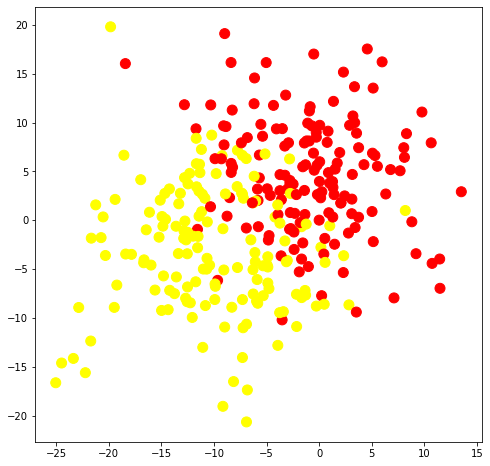

In [8]:
pylab.figure(figsize(8, 8))
pylab.scatter(list(map(lambda x: x[0], blobs[0])), list(map(lambda x: x[1], blobs[0])), c = blobs[1], cmap = 'autumn',
             s=100)
pylab.show()

## Сравнение линейных моделей

### Точечная оценка

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(blobs[0], blobs[1], 
                                                                                    test_size = 15,
                                                                                    random_state = 1)

In [73]:
lg = LogisticRegression(class_weight='balanced', solver='lbfgs')
lg.fit(X_train, y_train)
metrics.roc_auc_score(y_test, lg.predict(X_test))

0.8888888888888888

In [60]:
CatB = CatBoostClassifier(verbose=False, class_weights=[1,1], learning_rate=0.01, loss_function='Logloss')
CatB.fit(X_train, y_train)
metrics.roc_auc_score(y_test, CatB.predict(X_test))

0.8888888888888888

In [76]:
sgd_model = SGDClassifier(random_state = 1)
sgd_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, sgd_model.predict(test_data))

0.8888888888888888

In [68]:
ridge_model = RidgeClassifier()
ridge_model.fit(train_data, train_labels)
metrics.roc_auc_score(test_labels, ridge_model.predict(test_data))

0.8888888888888888

# Оценка среднего:

In [70]:
sgd_auc_scores = model_selection.cross_val_score(SGDClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

In [74]:
lgr_auc_scores = model_selection.cross_val_score(LogisticRegression(class_weight='balanced', solver='lbfgs'), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

In [77]:
cbc_auc_scores = model_selection.cross_val_score(CatBoostClassifier(verbose=False, class_weights=[1,1]), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

In [79]:
ridge_auc_scores = model_selection.cross_val_score(RidgeClassifier(), 
                                 blobs[0], blobs[1], scoring = 'roc_auc',  
                                 cv = 20)

# Точечная оценка среднего:

In [81]:
print("sgd model auc: mean %.3f, std %.3f" % (sgd_auc_scores.mean(), sgd_auc_scores.std(ddof=1)))
print("logistic reg model auc: mean %.3f, std %.3f" % (lgr_auc_scores.mean(), lgr_auc_scores.std(ddof=1)))
print("catboost model auc: mean %.3f, std %.3f" % (cbc_auc_scores.mean(), cbc_auc_scores.std(ddof=1)))
print("ridge model auc: mean %.3f, std %.3f" % (ridge_auc_scores.mean(), ridge_auc_scores.std(ddof=1)))

sgd model auc: mean 0.926, std 0.052
logistic reg model auc: mean 0.951, std 0.052
catboost model auc: mean 0.937, std 0.062
ridge model auc: mean 0.948, std 0.054


# Интервальная оценка:

In [82]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

In [83]:
sgd_mean = sgd_auc_scores.mean()
ridge_mean = ridge_auc_scores.mean()
cbc_mean = cbc_auc_scores.mean()
lgr_mean = lgr_auc_scores.mean()

#### z - интервал

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [87]:
print("sgd model mean auc 95%% confidence interval", _zconfint_generic(sgd_mean, 
                                                                  sqrt(0.25/len(sgd_auc_scores)), 
                                                                  0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", _zconfint_generic(ridge_mean, 
                                                                    sqrt(0.25/len(ridge_auc_scores)), 
                                                                    0.05, 'two-sided'))

print("catboost model mean auc 95%% confidence interval", _zconfint_generic(cbc_mean, 
                                                                    sqrt(0.25/len(cbc_auc_scores)), 
                                                                    0.05, 'two-sided'))

print("logistic reg. model mean auc 95%% confidence interval", _zconfint_generic(lgr_mean, 
                                                                    sqrt(0.25/len(lgr_auc_scores)), 
                                                                    0.05, 'two-sided'))

sgd model mean auc 95%% confidence interval (0.7070013801619768, 1.1452626504502676)
ridge model mean auc 95%% confidence interval (0.728860436284426, 1.1671217065727166)
catboost model mean auc 95%% confidence interval (0.7182896454680994, 1.15655091575639)
logistic reg. model mean auc 95%% confidence interval (0.7322245944476915, 1.1704858647359822)


#### t-интервал

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [93]:
sgd_mean_std = sgd_auc_scores.std(ddof=1)/sqrt(len(sgd_auc_scores))
ridge_mean_std = ridge_auc_scores.std(ddof=1)/sqrt(len(ridge_auc_scores))
cbc_mean_std = cbc_auc_scores.std(ddof=1)/sqrt(len(cbc_auc_scores))
lgr_mean_std = lgr_auc_scores.std(ddof=1)/sqrt(len(lgr_auc_scores))

In [95]:
print("sgd model mean auc 95%% confidence interval", _tconfint_generic(sgd_mean, sgd_mean_std,
                                                                       len(sgd_auc_scores) - 1,
                                                                       0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", _tconfint_generic(ridge_mean, ridge_mean_std,
                                                                         len(sgd_auc_scores) - 1,
                                                                         0.05, 'two-sided'))
print("catboost model mean auc 95%% confidence interval", _tconfint_generic(cbc_mean, cbc_mean_std,
                                                                       len(sgd_auc_scores) - 1,
                                                                       0.05, 'two-sided'))

print("logistic reg model mean auc 95%% confidence interval", _tconfint_generic(lgr_mean, lgr_mean_std,
                                                                         len(sgd_auc_scores) - 1,
                                                                         0.05, 'two-sided'))

sgd model mean auc 95%% confidence interval (0.9015650690703824, 0.9506989615418621)
ridge model mean auc 95%% confidence interval (0.9228783259302369, 0.9731038169269057)
catboost model mean auc 95%% confidence interval (0.9083442743863065, 0.9664962868381829)
logistic reg model mean auc 95%% confidence interval (0.9270615827871145, 0.9756488763965592)
